In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
# import tensorflow as tf 
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
train_df = pd.read_csv('./csv/trg1.csv', parse_dates=['frame_id'], index_col='frame_id')
val_df = pd.read_csv('./csv/val1.csv', parse_dates=['frame_id'], index_col='frame_id')
test_df = pd.read_csv('./csv/test1.csv', parse_dates=['frame_id'], index_col='frame_id')

In [14]:
train_inst_ids =  np.unique(train_df["instance_id"].values)
val_inst_ids = np.unique(val_df["instance_id"].values)
test_inst_ids = np.unique(test_df["instance_id"].values)
cols = list(train_df)[1:3]

print(len(train_inst_ids))
print(len(val_inst_ids))
print(len(test_inst_ids))
print(cols)

2740
778
787
['x', 'y']


In [4]:
def sliding_windows(data, seq_length):
    x = []
    predicted_ls = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        predicted = data[i+seq_length]
        x.append(_x)
        predicted_ls.append(predicted)

    return np.array(x), np.array(predicted_ls)

In [32]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Tensors in (batch, seq, feature)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(hidden_size, 1)

        # self.hidden1 = nn.Linear(hidden_size, hidden_size)
        # self.hidden2 = nn.Linear(hidden_size, hidden_size)
        # self.hidden3 = nn.Linear(hidden_size, hidden_size)
        # self.hidden4 = nn.Linear(hidden_size, hidden_size)

    def forward(self, data):
        h_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        out, (_, _) = self.lstm(data, (h_0, c_0))

        out = out[:,-1,:]
        
        # out = self.hidden4(self.hidden3(self.hidden2(self.hidden1(out))))
        
        out_x = self.fc1(out)
        out_y = self.fc2(out)

        return out_x, out_y

In [6]:
def conv_and_reshape(x, y):

    X = torch.tensor(x, dtype=torch.float32)
    Y = torch.tensor(y, dtype=torch.float32)

    if len(X.shape) == 1:
        X = torch.reshape(X, (X.shape[0],1))
        Y = torch.reshape(Y, (Y.shape[0],1))
    elif len(X.shape) == 2:
        X = torch.reshape(X, (X.shape[0],X.shape[1],1))
        Y = torch.reshape(Y, (Y.shape[0],Y.shape[1],1))
    return X, Y

In [44]:
def get_data(df, inst_id, seq_length):
    target_df = df[df.instance_id == inst_id]

    df_cols_training = target_df[cols]

    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_cols_training = scaler.fit_transform(df_cols_training)

    df_cols_training_x = df_cols_training[:,0]
    df_cols_training_y = df_cols_training[:,1]

    x, expected_x = sliding_windows(df_cols_training_x, seq_length)
    y, expected_y = sliding_windows(df_cols_training_y, seq_length)

    dataX, dataY = conv_and_reshape(x,y)
    expected_x, expected_y = conv_and_reshape(expected_x, expected_y)

    return dataX, dataY, expected_x, expected_y

In [32]:
def get_all_data(df, inst_id, seq_length):
    target_df = df[df.instance_id == inst_id]

    df_cols_training = target_df[cols]

    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_cols_training = scaler.fit_transform(df_cols_training)

    df_cols_training_x = df_cols_training[:,0]
    df_cols_training_y = df_cols_training[:,1]
    df_cols_training_z = df_cols_training[:,2]
    df_cols_training_r = df_cols_training[:,3]

    x, expected_x = sliding_windows(df_cols_training_x, seq_length)
    y, expected_y = sliding_windows(df_cols_training_y, seq_length)
    z, expected_z = sliding_windows(df_cols_training_z, seq_length)
    r, expected_r = sliding_windows(df_cols_training_r, seq_length)

    dataX, dataY = conv_and_reshape(x,y)
    dataZ, dataR = conv_and_reshape(z,r)
    expected_x, expected_y = conv_and_reshape(expected_x, expected_y)
    expected_z, expected_r = conv_and_reshape(expected_z, expected_r)

    return dataX, dataY, expected_x, expected_y, dataZ, dataR, expected_z, expected_r

In [30]:
def train(lstm, train_df, train_inst_ids, seq_length):
  lstm.train()

  log_interval = 200
  train_loss = 0
  rep_loss = 0 

  for idx, inst_id in enumerate(train_inst_ids):
    # Loop around dataset
    optimizer.zero_grad()

    # forward propagation
    dataX, dataY, expected_x, expected_y = get_data(train_df, inst_id, seq_length)
    # dataX, dataY, expected_x, expected_y, dataZ, dataR, expected_z, expected_r = get_all_data(train_df, inst_id, seq_length)
    
    cat_data = torch.cat([dataX, dataY], dim=2)
    # cat_all_data = torch.cat([dataX, dataY, dataZ, dataR], dim=2)

    predicted_output_x, predicted_output_y = lstm(cat_data)

    # obtain the loss function
    loss_x = criterion(predicted_output_x, expected_x)
    loss_y = criterion(predicted_output_y, expected_y)
    
    loss = loss_x + loss_y
    train_loss += loss
    rep_loss += loss
    
    loss.backward()
    optimizer.step()

    if idx % log_interval == 0 and idx > 0:
      print(f"| Epoch {epoch:3d} | {idx:5d}/{len(train_inst_ids):5d} batches | loss: {rep_loss/log_interval:8.3f}")
      rep_loss = 0
  return train_loss/len(train_inst_ids)

In [9]:
def validation(lstm, val_df, val_inst_ids, seq_length):
    lstm.eval()
    cum_loss = 0

    with torch.no_grad():
        for idx, inst_id in enumerate(val_inst_ids):
            # forward propagation
            dataX, dataY, expected_x, expected_y = get_data(val_df, inst_id, seq_length)
            # dataX, dataY, expected_x, expected_y, dataZ, dataR, expected_z, expected_r = get_all_data(val_df, inst_id, seq_length)
            
            cat_data = torch.cat([dataX, dataY], dim=2)
            # cat_all_data = torch.cat([dataX, dataY, dataZ, dataR], dim=2)

            predicted_output_x, predicted_output_y = lstm(cat_data)

            # obtain the loss function
            loss_x = criterion(predicted_output_x, expected_x)
            loss_y = criterion(predicted_output_y, expected_y)

            loss = loss_x + loss_y
            cum_loss += loss
    print(f'| Validation Epoch {epoch:3d} | Avg-Val Loss: {cum_loss/(len(val_inst_ids))}') 

    return cum_loss/len(val_inst_ids)

In [55]:
num_epochs = 100
learning_rate = 0.001

input_size = 2
hidden_size = 2
num_layers = 1

seq_length = 6

tl = []
vl = []

lstm = LSTM(input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

min_val_loss = 1000
stop_trigger = 0
patience = 5

# Train the model
for epoch in range(1,num_epochs+1):
    train_loss = train(lstm, train_df, train_inst_ids, seq_length)
    val_loss = validation(lstm, val_df, val_inst_ids, seq_length)
    tl.append(train_loss.item())
    vl.append(val_loss.item())

    if val_loss.item() <= round(min_val_loss,3):
        min_val_loss = val_loss.item()
        stop_trigger = 0 # Reset count
    
    elif val_loss.item() > round(min_val_loss,3):
        stop_trigger += 1
        print(f"| Trigger Count | {stop_trigger}/{patience}")

    if stop_trigger == patience:
        print("Early Stopped!!!")
        break

    torch.save(lstm.state_dict(), f'checkpoints/checkpt_{epoch}.pt')

print("Min Val Loss: ", min_val_loss)

| Epoch   1 |   200/ 2740 batches | loss:    0.898
| Epoch   1 |   400/ 2740 batches | loss:    0.601
| Epoch   1 |   600/ 2740 batches | loss:    0.648
| Epoch   1 |   800/ 2740 batches | loss:    0.504
| Epoch   1 |  1000/ 2740 batches | loss:    0.440
| Epoch   1 |  1200/ 2740 batches | loss:    0.365
| Epoch   1 |  1400/ 2740 batches | loss:    0.266
| Epoch   1 |  1600/ 2740 batches | loss:    0.200
| Epoch   1 |  1800/ 2740 batches | loss:    0.150
| Epoch   1 |  2000/ 2740 batches | loss:    0.124
| Epoch   1 |  2200/ 2740 batches | loss:    0.092
| Epoch   1 |  2400/ 2740 batches | loss:    0.092
| Epoch   1 |  2600/ 2740 batches | loss:    0.064
| Validation Epoch   1 | Avg-Val Loss: 0.06633158028125763
| Epoch   2 |   200/ 2740 batches | loss:    0.058
| Epoch   2 |   400/ 2740 batches | loss:    0.056
| Epoch   2 |   600/ 2740 batches | loss:    0.046
| Epoch   2 |   800/ 2740 batches | loss:    0.051
| Epoch   2 |  1000/ 2740 batches | loss:    0.040
| Epoch   2 |  1200/ 27

In [56]:
def plot_loss(tl, vl): 
    plt.figure(figsize=(10,10))
    epovec=range(len(tl))
    plt.plot(epovec,tl,epovec,vl,linewidth=3)
    plt.legend(('Train_loss','Val_loss'))

    # make the graph understandable: 
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

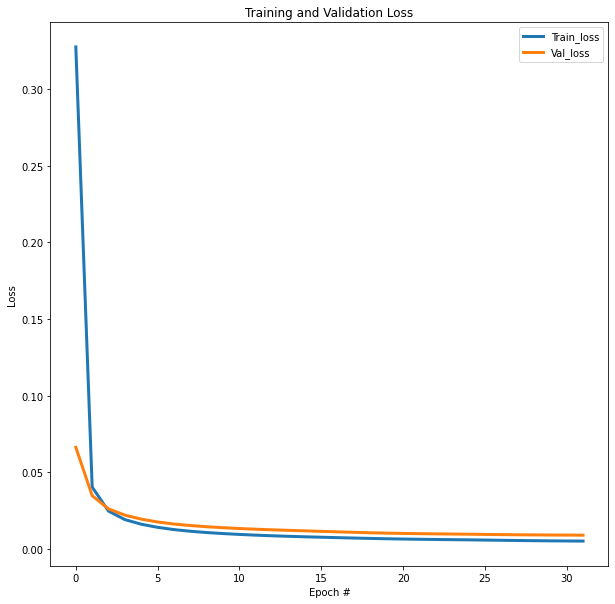

In [57]:
plot_loss(tl, vl)

In [26]:
def compute_ADE(pred_arr, gt_arr):
    ade = 0.0
    for pred, gt in zip(pred_arr, gt_arr):
        diff = pred - np.expand_dims(gt, axis=0)        # samples x frames x 2
        dist = np.linalg.norm(diff, axis=-1)            # samples x frames
        dist = dist.mean(axis=-1)                       # samples
        ade += dist.min(axis=0)                         # (1, )
    ade /= len(pred_arr)
    return ade


def compute_FDE(pred_arr, gt_arr):
    fde = 0.0
    for pred, gt in zip(pred_arr, gt_arr):
        diff = pred - np.expand_dims(gt, axis=0)        # samples x frames x 2
        dist = np.linalg.norm(diff, axis=-1)            # samples x frames
        dist = dist[..., -1]                            # samples 
        fde += dist.min(axis=0)                         # (1, )
    fde /= len(pred_arr)
    return fde


In [48]:
# PATH = './checkpoints/best_checkpt_16.pt'
# PATH = './checkpoints/best_checkpt_norm.pt'
# PATH = './checkpoints/best_checkpt_nohl.pt'
# PATH = './checkpoints/best_checkpt_seq6.pt'
# PATH = './checkpoints/best_checkpt_allinputs.pt'
PATH = './checkpoints/norm_40.pt'
input_size = 2
hidden_size = 2
num_layers = 1

num_classes = 2
seq_length = 4

frames_to_predict = 6

lstm = LSTM(input_size, hidden_size, num_layers)
lstm.load_state_dict(torch.load(PATH))

test_df = pd.read_csv('./csv/test1.csv', parse_dates=['frame_id'], index_col='frame_id')
test_inst_ids = np.unique(test_df["instance_id"].values)

In [49]:
def look_ahead_test(lstm, test_df, test_inst_ids, test_id, frames_to_predict, start):
        
    test_df = test_df[test_df.instance_id == test_inst_ids[test_id]]
    cols = list(test_df)[1:3]

    df_cols_testing = test_df[cols]

    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_cols_testing = scaler.fit_transform(df_cols_testing)

    df_cols_testing_x, df_cols_testing_y = df_cols_testing[:,0], df_cols_testing[:,1]

    x, expected_x = sliding_windows(df_cols_testing_x, seq_length)
    y, expected_y = sliding_windows(df_cols_testing_y, seq_length)

    x, expected_x = [x[start]], expected_x[start:]
    y, expected_y = [y[start]], expected_y[start:]

    original_x, original_y = df_cols_testing_x[:start+seq_length], df_cols_testing_y[:start+seq_length]

    dataX, dataY = conv_and_reshape(x,y)
    
    original_x, original_y = conv_and_reshape(original_x, original_y)
    expected_x, expected_y = conv_and_reshape(expected_x, expected_y)

    lstm.eval()
    with torch.no_grad():
        predicted_data = []
        cat_data = torch.cat([dataX, dataY], dim=2)

        for i in range(frames_to_predict):
            predicted_output_x, predicted_output_y = lstm(cat_data)

            combined_predicted_output = torch.cat([predicted_output_x, predicted_output_y], dim=1)

            new_cat_data = cat_data[0][1:]

            new_data = torch.cat([new_cat_data, combined_predicted_output])
            cat_data = torch.reshape(new_data, (1,new_data.shape[0], new_data.shape[1]))
            # print(f"round {i}:\n{cat_data}")

            data_predict = scaler.inverse_transform(combined_predicted_output)
            predicted_data.append(data_predict[0])

        combined_original_traj = torch.cat([original_x, original_y], dim=1)
        combined_expected_traj = torch.cat([expected_x, expected_y], dim=1)

        data_original = scaler.inverse_transform(combined_original_traj)
        data_expected = scaler.inverse_transform(combined_expected_traj)

        pred_data = np.reshape(predicted_data, (len(predicted_data),len(predicted_data[0])))

    return pred_data, data_expected, data_original

In [169]:
def look_ahead_test_all(lstm, test_df, test_inst_ids, test_id, frames_to_predict, start):
        
    test_df = test_df[test_df.instance_id == test_inst_ids[test_id]]
    cols = list(test_df)[1:5]

    df_cols_testing = test_df[cols]

    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_cols_testing = scaler.fit_transform(df_cols_testing)

    df_cols_testing_x, df_cols_testing_y = df_cols_testing[:,0], df_cols_testing[:,1]
    df_cols_testing_z, df_cols_testing_r = df_cols_testing[:,2],  df_cols_testing[:,3]

    x, expected_x = sliding_windows(df_cols_testing_x, seq_length)
    y, expected_y = sliding_windows(df_cols_testing_y, seq_length)
    z, expected_z = sliding_windows(df_cols_testing_z, seq_length)
    r, expected_r = sliding_windows(df_cols_testing_r, seq_length)

    x, expected_x = [x[start]], expected_x[start:]
    y, expected_y = [y[start]], expected_y[start:]
    z, expected_z = [z[start]], expected_z[start:]
    r, expected_r = [r[start]], expected_r[start:]

    original_x, original_y = df_cols_testing_x[:start+seq_length], df_cols_testing_y[:start+seq_length]
    original_z, original_r = df_cols_testing_z[:start+seq_length], df_cols_testing_r[:start+seq_length]

    dataX, dataY = conv_and_reshape(x,y)
    dataZ, dataR = conv_and_reshape(z,r)
    
    original_x, original_y = conv_and_reshape(original_x, original_y)
    original_z, original_r = conv_and_reshape(original_z, original_r)
    expected_x, expected_y = conv_and_reshape(expected_x, expected_y)
    expected_z, expected_r = conv_and_reshape(expected_z, expected_r)

    lstm.eval()
    with torch.no_grad():
        predicted_data = []
        cat_all_data = torch.cat([dataX, dataY, dataZ, dataR], dim=2)

        for i in range(frames_to_predict):
            predicted_output_x, predicted_output_y = lstm(cat_all_data)
            
            temp_z = torch.reshape(expected_z[i], (1,expected_z[i].shape[0]))
            temp_r = torch.reshape(expected_r[i], (1,expected_r[i].shape[0]))
            
            combined_predicted_output = torch.cat([predicted_output_x, predicted_output_y, temp_z, temp_r], dim=1)

            new_cat_data = cat_all_data[0][1:]

            new_data = torch.cat([new_cat_data, combined_predicted_output])
            cat_all_data = torch.reshape(new_data, (1,new_data.shape[0], new_data.shape[1]))
            # print(f"round {i}:\n{cat_all_data}")

            data_predict = scaler.inverse_transform(combined_predicted_output)

            predicted_data.append(data_predict[0][:2])

        combined_original_traj = torch.cat([original_x, original_y, original_z, original_r], dim=1)
        combined_expected_traj = torch.cat([expected_x, expected_y, expected_z, expected_r], dim=1)
        data_original = scaler.inverse_transform(combined_original_traj)
        data_expected = scaler.inverse_transform(combined_expected_traj)
        pred_data = np.reshape(predicted_data, (len(predicted_data),len(predicted_data[0])))

    return pred_data, data_expected[:,:2], data_original[:,:2]

In [50]:
results_look_ahead = {}
avg_ade = 0
avg_fde = 0
for i in range(len(test_inst_ids)):
    predicted_data, data_expected, data_original = look_ahead_test(lstm, test_df, test_inst_ids, i, frames_to_predict, 0)
    ade = compute_ADE(predicted_data, data_expected)
    fde = compute_FDE(predicted_data, data_expected)
    avg_ade +=ade
    avg_fde +=fde
    results_look_ahead[i] = [predicted_data, data_expected, data_original, ade, fde]

avg_ade = avg_ade/len(test_inst_ids)
avg_fde = avg_fde/len(test_inst_ids)

In [51]:
print(f"ADE: {avg_ade}")
print(f"FDE: {avg_fde}")

ADE: 3.101906425040461
FDE: 3.101906425040461


In [151]:
def plot_results(num, predicted_data, data_expected, data_original=None):
    original_plot_x, original_plot_y = [], []
    expected_plot_x, expected_plot_y = [], []
    data_predict_x, data_predict_y = [], []

    for i in data_expected:
        expected_plot_x.append(i[0])
        expected_plot_y.append(i[1])
    for i in predicted_data:
        data_predict_x.append(i[0])
        data_predict_y.append(i[1])
    if data_original is not None:
        for i in data_original:
            original_plot_x.append(i[0])
            original_plot_y.append(i[1])
        plt.scatter(original_plot_x,original_plot_y, marker=".",color="b",label='Input')
    

    ulti_min_x = min(min(original_plot_x),min(expected_plot_x))
    ulti_min_y = min(min(original_plot_y),min(expected_plot_y))
    ulti_max_x = max(max(original_plot_x),max(expected_plot_x))
    ulti_max_y = max(max(original_plot_y),max(expected_plot_y))

    plt.scatter(expected_plot_x,expected_plot_y, marker=".", color="g",label='Expected')
    plt.scatter(data_predict_x,data_predict_y, marker=".", color="r",label='Predicted')
    plt.scatter(expected_plot_x[0],expected_plot_y[0], color="b", marker="s", s=200, label='Car')
    plt.xlim(ulti_min_x-10, ulti_max_x+10)
    plt.ylim(ulti_min_y-10, ulti_max_y+10)
    plt.suptitle('Time-Series Prediction')
    plt.legend()
    # plt.savefig("pictures/myfig"+str(num)+".jpeg")
    plt.show()

10
Frame 0


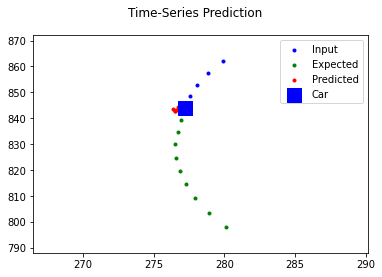

Frame 1


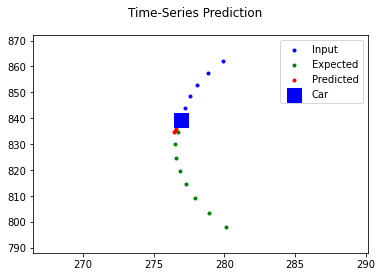

Frame 2


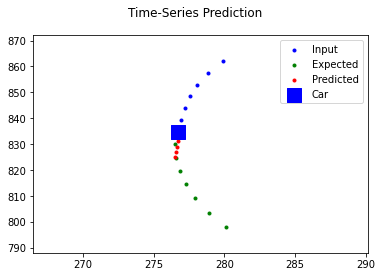

Frame 3


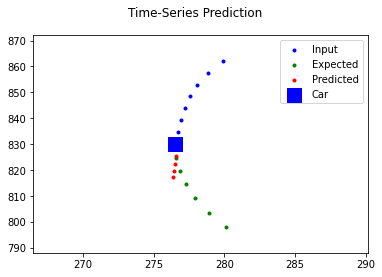

Frame 4


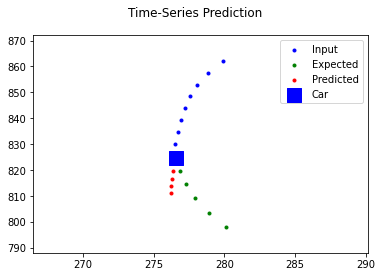

In [174]:
index = 19
_, data_expected, _= look_ahead_test_all(lstm, test_df, test_inst_ids, index, frames_to_predict, 0)
num_of_times = len(data_expected)
print(num_of_times)
for i in range(num_of_times-5):
    print(f"Frame {i}")
    predicted_data, data_expected, data_original = look_ahead_test_all(lstm, test_df, test_inst_ids, index, frames_to_predict, i)
    plot_results(i, predicted_data, data_expected, data_original)

In [345]:
import imageio
import natsort
images = []
for filename in natsort.natsorted(os.listdir("./pictures/")):
    print(filename)
    for i in range(4):
        images.append(imageio.imread("./pictures/"+filename))
imageio.mimsave('./gif/path6.gif', images)

for filename in natsort.natsorted(os.listdir("./pictures/")):
    os.remove("./pictures/"+filename)

myfig0.jpeg
myfig1.jpeg
myfig2.jpeg
myfig3.jpeg
myfig4.jpeg
myfig5.jpeg
myfig6.jpeg
myfig7.jpeg
myfig8.jpeg
myfig9.jpeg
myfig10.jpeg
myfig11.jpeg
myfig12.jpeg
myfig13.jpeg
myfig14.jpeg
myfig15.jpeg
myfig16.jpeg
myfig17.jpeg
myfig18.jpeg
myfig19.jpeg
myfig20.jpeg
myfig21.jpeg
myfig22.jpeg
myfig23.jpeg
myfig24.jpeg
myfig25.jpeg
myfig26.jpeg
myfig27.jpeg


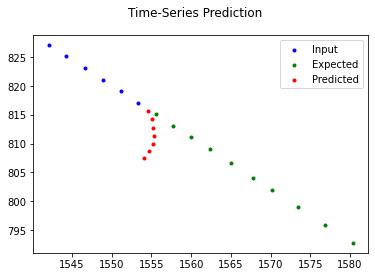

In [161]:
index = 29
plot_results(results_look_ahead[index][0],results_look_ahead[index][1],results_look_ahead[index][2])

In [52]:
def one_step_test(lstm, test_df, test_inst_ids, test_id, frames_to_predict):
        
    test_df = test_df[test_df.instance_id == test_inst_ids[test_id]]
    cols = list(test_df)[1:3]

    df_cols_testing = test_df[cols]

    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_cols_testing = scaler.fit_transform(df_cols_testing)

    df_cols_testing_x, df_cols_testing_y = df_cols_testing[:,0], df_cols_testing[:,1]

    x, expected_x = sliding_windows(df_cols_testing_x, seq_length)
    y, expected_y = sliding_windows(df_cols_testing_y, seq_length)

    dataX, dataY = conv_and_reshape(x,y)
    expected_x, expected_y = conv_and_reshape(expected_x, expected_y)

    lstm.eval()
    with torch.no_grad():
        cat_data = torch.cat([dataX, dataY], dim=2)

        predicted_output_x, predicted_output_y = lstm(cat_data)
        combined_predicted_output = torch.cat([predicted_output_x, predicted_output_y], dim=1)
        combined_expected_traj = torch.cat([expected_x, expected_y], dim=1)

        data_predict = scaler.inverse_transform(combined_predicted_output)
        data_expected = scaler.inverse_transform(combined_expected_traj)

        # pred_data = np.reshape(predicted_data, (len(predicted_data),len(predicted_data[0])))

    return data_predict, data_expected
    # return combined_predicted_output, combined_expected_traj

In [53]:
results_one_step = {}
avg_ade = 0
avg_fde = 0
for i in range(len(test_inst_ids)):
    predicted_data, data_expected = one_step_test(lstm, test_df, test_inst_ids, i, frames_to_predict)
    ade = compute_ADE(predicted_data, data_expected)
    fde = compute_FDE(predicted_data, data_expected)
    avg_ade +=ade
    avg_fde +=fde
    results_one_step[i] = [predicted_data, data_expected, ade, fde]

avg_ade = avg_ade/len(test_inst_ids)
avg_fde = avg_fde/len(test_inst_ids)

In [54]:
print(f"ADE: {avg_ade}")
print(f"FDE: {avg_fde}")

ADE: 0.7373255129725956
FDE: 0.7373255129725956


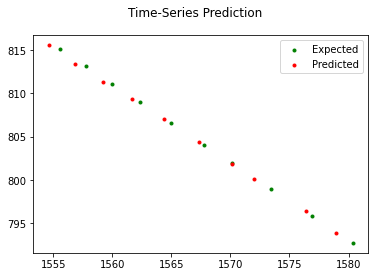

In [109]:
plot_results(results_one_step[index][0],results_one_step[index][1])

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Actual X', 'Predicted X', 'Actual Y', 'Predicted Y'])
for i in range(len(expected_plot_x)):
    t.add_row([expected_plot_x[i], data_predict_x[i], expected_plot_y[i], data_predict_y[i]])
print(t)

+----------+-------------+----------+-------------+
| Actual X | Predicted X | Actual Y | Predicted Y |
+----------+-------------+----------+-------------+
| 764.058  |  765.34937  | 1485.037 |  1487.4156  |
| 764.971  |  765.31744  | 1486.542 |  1487.4729  |
| 765.829  |    765.39   | 1488.039 |  1487.3425  |
|  766.57  |   765.3722  | 1489.334 |  1487.3746  |
| 767.311  |  765.36975  | 1490.63  |  1487.3789  |
| 767.385  |  765.38007  | 1490.771 |  1487.3605  |
| 767.459  |  765.38007  | 1490.912 |  1487.3605  |
| 767.516  |  765.38745  | 1491.02  |  1487.3472  |
| 767.572  |  765.38794  | 1491.127 |  1487.3463  |
+----------+-------------+----------+-------------+
